In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

module_path = (Path().resolve().parent/ "Modules")
sys.path.append(str(module_path))

import my_modules, model_tuner, features

pd.set_option("display.max_columns", None)
pd.set_option("display.max_info_columns", 100)

In [2]:
df = pd.read_csv("../Data/train_data_tmp.csv", encoding="shift-jis")
odds_df = pd.read_csv("../Data/Time_Series_Odds_win_odds.csv", encoding="shift-jis")

In [3]:
df2 = my_modules.preprocessing(df)

In [4]:
df3 = my_modules.common_process(df2)

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\my_modules.py:76: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["place_num"] = df["place"].replace(place_dict).astype(int)


In [5]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252411 entries, 252634 to 0
Data columns (total 74 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PCI                  251103 non-null  float64       
 1   PCI3                 252411 non-null  float64       
 2   RPCI                 252411 non-null  float64       
 3   race_id              252411 non-null  int64         
 4   year                 252411 non-null  int64         
 5   month                252411 non-null  int64         
 6   day                  252411 non-null  int64         
 7   times                252411 non-null  int64         
 8   place                252411 non-null  object        
 9   daily                252411 non-null  object        
 10  race_num             252411 non-null  int64         
 11  horse                252411 non-null  object        
 12  jockey_id            252411 non-null  object        
 13  trainer_id         

In [6]:
feature_col = ["waku_num", "horse_num", "sex", "age", "basis_weight", "weight", "inc_dec"]
df4, feature_col2 = features.feature_engineering(df3, feature_col)

calculating trueskill of horse is processing
calculating trueskill of jockey is processing
['waku_num', 'horse_num', 'sex', 'age', 'basis_weight', 'weight', 'inc_dec', 'weight_last_1', 'weight_last_2', 'weight_last_3', 'weight_mean_last_1_to_3', 'weight_mean_all', 'inc_dec_last_1', 'inc_dec_last_2', 'inc_dec_last_3', 'inc_dec_mean_last_1_to_3', 'inc_dec_mean_all', 'last_3F_time_last_1', 'last_3F_time_last_2', 'last_3F_time_last_3', 'last_3F_time_mean_last_1_to_3', 'last_3F_time_mean_all', 'Ave_3F_last_1', 'Ave_3F_last_2', 'Ave_3F_last_3', 'Ave_3F_mean_last_1_to_3', 'Ave_3F_mean_all', 'all_win_rate_horse', 'all_win_rate3_horse', 'horse_win_rate_dist', 'horse_win_rate3_dist', 'horse_win_rate_track_code', 'horse_win_rate3_track_code', 'horse_win_rate_field_type', 'horse_win_rate3_field_type', 'horse_win_rate_turn_type', 'horse_win_rate3_turn_type', 'horse_win_rate_weather', 'horse_win_rate3_weather', 'horse_win_rate_state', 'horse_win_rate3_state', 'horse_win_rate_place', 'horse_win_rate3

,PCI,PCI3,RPCI,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_odds_1,win_odds_1_pop,win_odds_2,win_odds_2_pop,win_mul_odds_Hi,win_mul_odds_Lo,win_mul_odds_1_Hi,win_mul_odds_1_Lo,win_mul_odds_1_pop,win_mul_odds_2_Hi,win_mul_odds_2_Lo,win_mul_odds_2_pop,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,target,target3,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,horse_win_rate_dist,horse_win_rate3_dist,horse_win_rate_track_code,horse_win_rate3_track_code,horse_win_rate_field_type,horse_win_rate3_field_type,horse_win_rate_turn_type,horse_win_rate3_turn_type,horse_win_rate_weather,horse_win_rate3_weather,horse_win_rate_state,horse_win_rate3_state,horse_win_rate_place,horse_win_rate3_place,horse_win_rate_corner_num,horse_win_rate3_corner_num,horse_win_rate_class_code,horse_win_rate3_class_code,horse_win_rate_basis_weight,horse_win_rate3_basis_weight,horse_win_rate_age_code,horse_win_rate3_age_code,horse_win_rate_weight_code,horse_win_rate3_weight_code,horse_win_rate_jockey_id,horse_win_rate3_jockey_id,horse_win_rate_jockey_id_class_code,horse_win_rate3_jockey_id_class_code,horse_win_rate_jockey_id_place,horse_win_rate3_jockey_id_place,horse_win_rate_jockey_id_dist,horse_win_rate3_jockey_id_dist,horse_win_rate_jockey_id_field_type,horse_win_rate3_jockey_id_field_type,horse_win_rate_jockey_id_place_dist,horse_win_rate3_jockey_id_place_dist,horse_win_rate_jockey_id_place_field_type_dist,horse_win_rate3_jockey_id_place_field_type_dist,horse_win_rate_weather_state,horse_win_rate3_weather_state,horse_win_rate_dist_corner_num,horse_win_rate3_dist_corner_num,horse_win_rate_dist_track_code,horse_win_rate3_dist_track_code,horse_win_rate_dist_class_code,horse_win_rate3_dist_class_code,horse_win_rate_place_field_type_dist,horse_win_rate3_place_field_type_dist,horse_win_rate_place_field_type_dist_class_code,horse_win_rate3_place_field_type_dist_class_code,all_win_rate_horse,all_win_rate3_horse,all_win_rate_dist_waku,all_win_rate3_dist_waku,all_win_rate_field_type_waku,all_win_rate3_field_type_waku,all_win_rate_place_waku,all_win_rate3_place_waku,all_win_rate_field_type_dist_waku,all_win_rate3_field_type_dist_waku,all_win_rate_dist_place_waku,all_win_rate3_dist_place_waku,all_win_rate_field_type_place_waku,all_win_rate3_field_type_place_waku,all_win_rate_race_type_waku,all_win_rate3_race_type_waku,all_win_rate_corner_num_waku,all_win_rate3_corner_num_waku,all_win_rate_corner_num_dist_waku,all_win_rate3_corner_num_dist_waku,all_win_rate_corner_num_place_waku,all_win_rate3_corner_num_place_waku,all_win_rate_corner_num_field_type_waku,all_win_rate3_corner_num_field_type_waku,all_win_rate_jockey_id,all_win_rate3_jockey_id,all_win_rate_jockey_id_place,all_win_rate3_jockey_id_place,all_win_rate_jockey_id_place_dist,all_win_rate3_jockey_id_place_dist,all_win_rate_jockey_id_field_type,all_win_rate3_jockey_id_field_type,all_win_rate_jockey_id_field_type_dist,all_win_rate3_jockey_id_field_type_dist,all_win_rate_jockey_id_field_type_place,all_win_rate3_jockey_id_field_type_place,all_win_rate_jockey_id_dist,all_win_rate3_jockey_id_dist,all_win_rate_jockey_id_race_type,all_win_rate3_jockey_id_race_type,all_win_rate_jockey_id_race_type_waku,all_win_rate3_jockey_id_race_type_waku,all_win_rate_jockey_id_class_code,all_win_rate3_jockey_id_c

[I 2025-06-23 14:42:40,851] A new study created in memory with name: no-name-904bd55e-b380-46b1-b1c9-79f5bb35d1f5
[I 2025-06-23 14:42:47,962] Trial 0 finished with value: 0.21771457326548366 and parameters: {'max_bin': 102, 'num_leaves': 96, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 5.9865848459837805, 'bagging_fraction': 0.3248149123539492, 'bagging_freq': 16, 'feature_fraction': 0.15227525095137953, 'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598, 'min_gain_to_split': 7.080725777960454, 'max_depth': 4, 'learning_rate': 0.7579479953348001, 'path_smooth': 8.324426408004218}. Best is trial 0 with value: 0.21771457326548366.
[I 2025-06-23 14:43:15,213] Trial 1 finished with value: 0.21218641323388593 and parameters: {'max_bin': 62, 'num_leaves': 20, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3.0424224365529544, 'bagging_fraction': 0.6198051453057902, 'bagging_freq': 44, 'feature_fraction': 0.36210622617823773, 'lambda_l1': 0.0032112643094417484, 'lambd

Best params :  {'max_bin': 226, 'num_leaves': 60, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 0.951910869600719, 'bagging_fraction': 0.8709376032717512, 'bagging_freq': 15, 'feature_fraction': 0.17141479895074663, 'lambda_l1': 2.9768024668887, 'lambda_l2': 0.1674765228715533, 'min_gain_to_split': 5.395178325691195, 'max_depth': 8, 'learning_rate': 0.006739214919177225, 'path_smooth': 9.254580994301927}


Sum of predict      is : 25
Sum of predict rate is : 0.0003289863


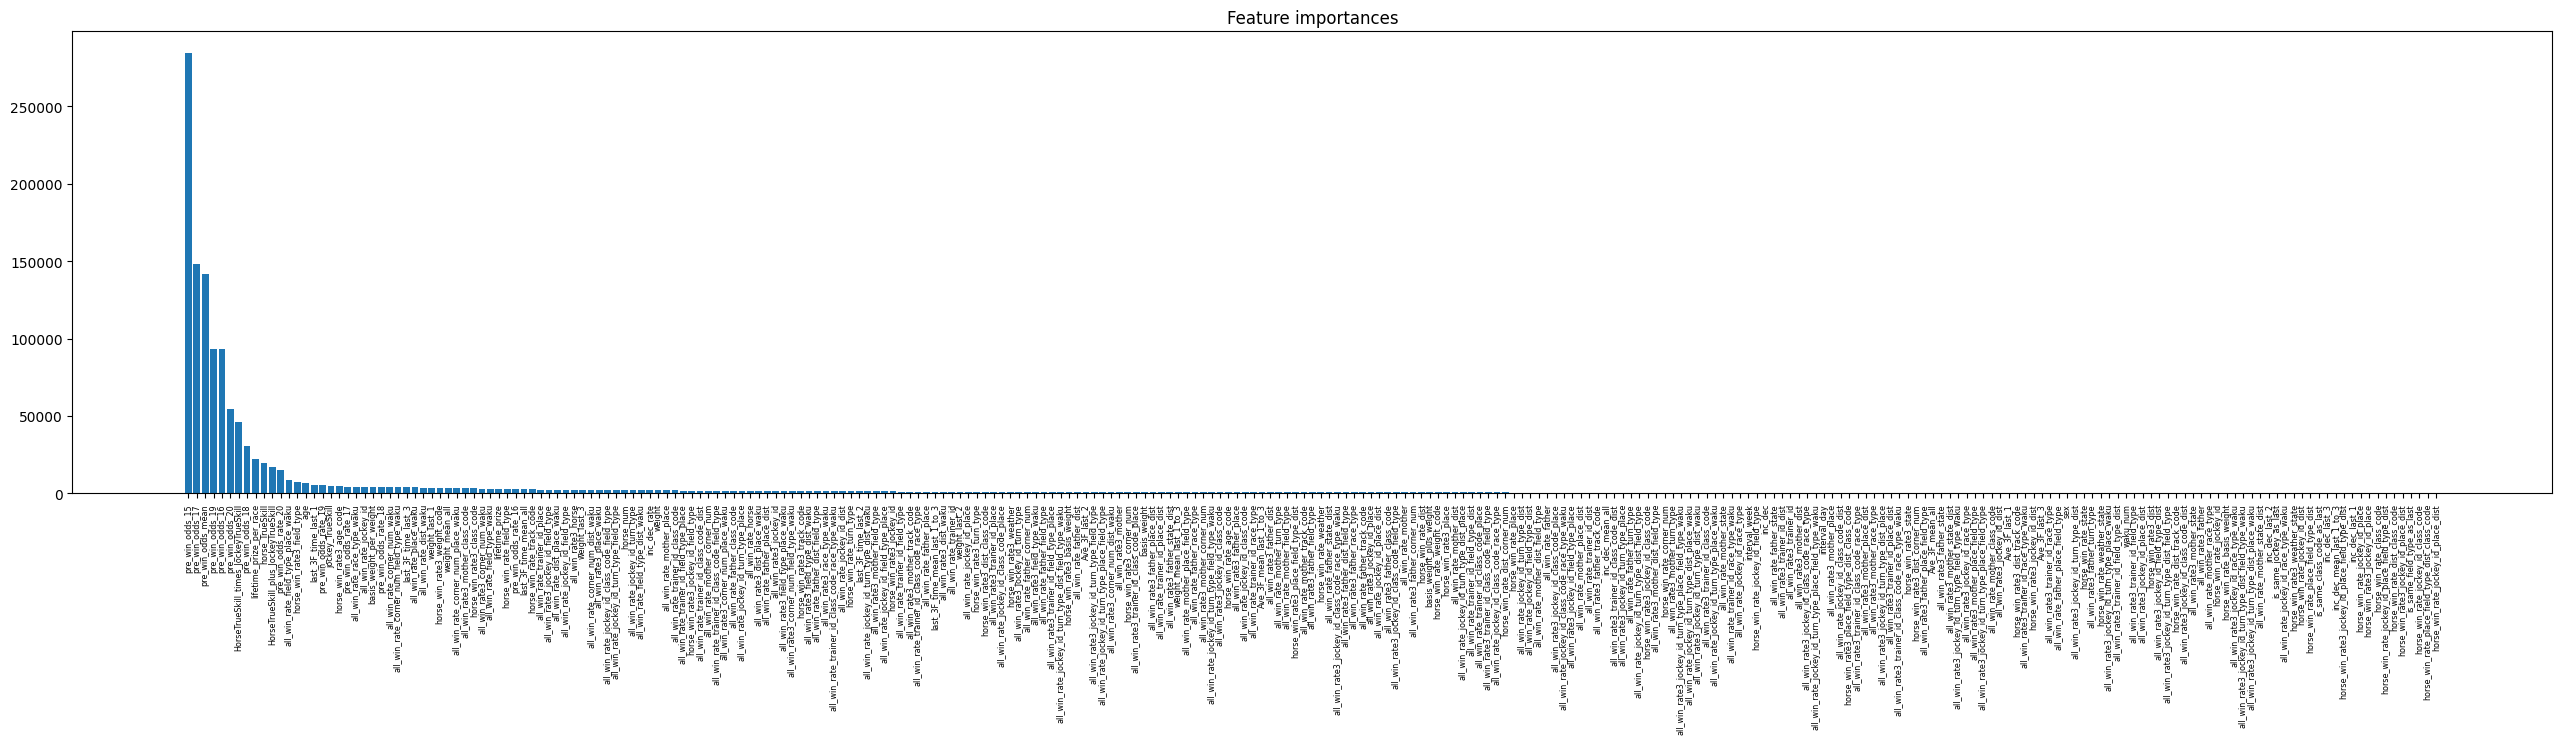

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\model_tuner.py:124: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\model_tuner.py:124: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\model_tuner.py:125: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) ins

In [7]:
memo = "add pre_win_odds, reduce features more. n_rials=50."
model, df_pred = model_tuner.simple_lightGBM(df4, feature_col2, memo=memo, n_trials=50, save_result=False, visualization=True)

In [8]:
tmp =  df_pred[df_pred["class_pred"] == 1][["id_for_fold", "horse", "pred"]].sort_values("pred", ascending=False)
tmp.head(10)

,id_for_fold,horse,pred
235021,2025020805010303,アドマイヤデイトナ,0.659074
189397,2024020405010407,アスコルティアーモ,0.573613
205779,2024060905030406,レッドアトレーヴ,0.558867
212143,2024072801010409,アドマイヤテラ,0.554137
204839,2024060205030204,フクチャントウメイ,0.547611
203869,2024052505021105,コンテネレッツア,0.547064
235451,2025020908010404,グランドプラージュ,0.544937
241221,2025032306020803,メモリアカフェ,0.542826
177760,2023110503030201,ベルウッドワン,0.541493
248212,2025051705020703,エムティエスターテ,0.538243


In [9]:
df_pred[df_pred["class_pred"] == 1][["id_for_fold", "horse", "pred"]].tail(10)

,id_for_fold,horse,pred
217523,2024091507030402,オトメナシャチョウ,0.522166
217987,2024091606040509,テリフィックプラン,0.511994
219772,2024100605040201,ドゥカート,0.521431
219786,2024100608050201,ダノンフィーゴ,0.519915
228046,2024120808070406,フェデラー,0.529312
235021,2025020805010303,アドマイヤデイトナ,0.659074
235451,2025020908010404,グランドプラージュ,0.544937
241221,2025032306020803,メモリアカフェ,0.542826
246856,2025050408020404,ダノンジョーカー,0.503088
248212,2025051705020703,エムティエスターテ,0.538243


In [60]:
# 各レースで、一番確率が高い単勝のみ購入した場合の勝ち額
def calc_max_pred_strategy(pred_df):
    pred_df["max_pred"] = pred_df.groupby("id_for_fold", observed=True)["pred"].transform("max")
    pred_df["max_pred_flg"] = pred_df["max_pred"] == pred_df["pred"]
    pred_df["bought_ticket_flg"] = pred_df["max_pred_flg"].astype(int)
    pred_df["bought_and_winning_odds"] = pred_df["bought_ticket_flg"] * pred_df["target"] * pred_df["win_odds"]


    # とりあえず100円賭ける
    total_win = pred_df["bought_and_winning_odds"].sum() * 100  # 払戻額（円単位）
    bought_ticket_sum = pred_df["bought_ticket_flg"].sum()
    total_bet = bought_ticket_sum * 100  # 賭け金（1点100円）
    net_profit = total_win - total_bet

    print(f"購入点数: {bought_ticket_sum}点")
    print(f"払い戻し合計: {total_win:.1f}円")
    print(f"投資額: {total_bet}円")
    print(f"収支: {net_profit:.1f}円")
    print(f"ROI（回収率）: {total_win / total_bet * 100:.2f}%")

calc_max_pred_strategy(df_pred)

購入点数: 5452点
払い戻し合計: 439230.0円
投資額: 545200円
収支: -105970.0円
ROI（回収率）: 80.56%


In [ ]:
tmp = df_pred[["race_id", "id_for_fold", "horse", "pred", "target", "win_odds"]]
pre_win_odds = odds_df[["race_id", "pre_win_odds_20"]]
tmp = pd.merge(left=tmp, right=pre_win_odds, how="left", on="race_id")
tmp["exp_value"] = tmp["pred"] * tmp["pre_win_odds_20"]
tmp.head()

,race_id,id_for_fold,horse,pred,target,win_odds,pre_win_odds_20,exp_value
0,202310280802080208,2023102808020802,サウンドルミネ,0.003405,0,467.0,453.1,1.542983
1,202310280802080212,2023102808020802,アルピニスト,0.124629,0,5.1,5.5,0.685459
2,202310280802080203,2023102808020802,レグノ,0.014091,0,65.4,64.0,0.901810
3,202310280802080201,2023102808020802,テイエムデンセツ,0.094441,0,13.8,13.8,1.303290
4,202310280802080210,2023102808020802,キモンキャリントン,0.015272,0,53.5,54.8,0.836900


In [59]:
def calc_max_exp_value_strategy(df):
    df["max_exp"] = df.groupby("id_for_fold", observed=True)["exp_value"].transform("max")
    df["max_exp_flg"] = (df["max_exp"] == df["exp_value"]) & (df["exp_value"] > 1) & (df["pred"] > 0.1) & (df["win_odds"] < 30)
    df["bought_ticket_flg"] = df["max_exp_flg"].astype(int)
    df["bought_and_winning_odds"] = df["bought_ticket_flg"] * df["target"] * df["win_odds"]

    # とりあえず100円賭ける
    total_win = df["bought_and_winning_odds"].sum() * 100  # 払戻額（円単位）
    bought_ticket_sum = df["bought_ticket_flg"].sum()
    total_bet = bought_ticket_sum * 100  # 賭け金（1点100円）
    net_profit = total_win - total_bet

    display(df[df["bought_ticket_flg"] == 1].head(20))

    print(f"購入点数: {bought_ticket_sum}点")
    print(f"払い戻し合計: {total_win:.1f}円")
    print(f"投資額: {total_bet}円")
    print(f"収支: {net_profit:.1f}円")
    print(f"ROI（回収率）: {total_win / total_bet * 100:.2f}%")

    return df

calc_df = calc_max_exp_value_strategy(tmp)

,race_id,id_for_fold,horse,pred,target,win_odds,pre_win_odds_20,exp_value,max_exp,max_exp_flg,bought_ticket_flg,bought_and_winning_odds
138,202310280802080610,2023102808020806,コンプラセンシア,0.101390,0,11.2,12.5,1.267375,1.267375,True,1,0.0
288,202310280504081008,2023102805040810,バルサムノート,0.162931,0,6.7,6.7,1.091636,1.091636,True,1,0.0
289,202310280802081002,2023102808020810,ジュタロウ,0.305948,0,4.7,4.7,1.437955,1.437955,True,1,0.0
351,202310280404051105,2023102804040511,セレシオン,0.203575,0,6.6,6.4,1.302881,1.302881,True,1,0.0
389,202310280404051204,2023102804040512,スマートメイプル,0.122414,0,11.6,10.2,1.248626,1.248626,True,1,0.0
414,202310290802090109,2023102908020901,ジーティースピカ,0.159929,0,6.5,6.5,1.039540,1.039540,True,1,0.0
439,202310290504090209,2023102905040902,メティエダール,0.268691,0,8.7,8.7,2.337611,2.337611,True,1,0.0
487,202310290504090301,2023102905040903,ニューステソーロ,0.242296,1,8.5,8.5,2.059519,2.059519,True,1,8.5
495,202310290802090313,2023102908020903,ルージュプレジール,0.131358,1,14.9,14.9,1.957232,1.957232,True,1,14.9
529,202310290504090410,2023102905040904,ヴェルヴ,0.173542,0,8.0,8.0,1.388334,1.388334,True,1,0.0


購入点数: 1536点
払い戻し合計: 127030.0円
投資額: 153600円
収支: -26570.0円
ROI（回収率）: 82.70%


In [65]:
tmp.drop(["exp_value", "max_exp", "max_exp_flg", "bought_ticket_flg", "bought_and_winning_odds"], axis=1).to_csv("predicted_odds.csv", index=False)